# Report Description Classification

This notebook compares the performance of report classification with preprocessing by Spacy and NLTK, and Complement Naive Bayes and SVM models.

> This notebook is based off Bo's [ski_learn_with_spacy_finetune.ipynb](https://github.com/Code-the-Change-YYC/YW-NLP-Report-Classifier/blob/02ff7a9e7f49779c736cbb55edb4e8d2835beddd/notebooks/machine_learning/ski_learn_with_spacy_finetune.ipynb)

## Data Specification

This notebook was tested with data preprocessed by `ReportData` with 335 training examples.

> Lemmatization in preprocessing **is not used** as it is performed in the notebook.

Commit tested at: `a9ed0b8b4587410fd969bce6481057b205d9049e`

## Results Summary

The results of multiple preprocessing combinations are summarized here:

![image.png](./images/description_classification_results_no_weights.png)
> Placeholder used is `'someone'`. w/o placeholders for scrubadub uses `'{{}}'` entities, and for spacy it uses `'*'` entities

## Setup

If running this notebook in Google Colab, upload the requested files and allow the dependencies to be installed. The file paths should be treated as relative to the colab file, create any folders necessary to satisfy the paths.

Otherwise update the path to allow for necessary imports.

In [ ]:
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    from google.colab import files

    required_files = [
        "requirements.txt",
        "data-processed.csv",
        "report_data.py",
        "report_data_d.py",
        "incident_types_d.py",
        "training/description_classification/utils.py",
        "training/description_classification/model_paths.py",
    ]
    for file in required_files:
        print(f"Upload {file}")
        files.upload()

    !pip install -r requirements.txt
else:
    from os import path

    root = path.abspath(path.join("..", ".."))
    sys.path.append(root)

    preprocess = path.join(root, "preprocess")
    sys.path.append(preprocess)

    incident_types = path.join(preprocess, "incident_types")
    sys.path.append(incident_types)

In [2]:
import pickle
from tempfile import mkdtemp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import set_config
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    plot_confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight

from incident_types_d import IncidentType
from report_data import ReportData
from report_data_d import ColName
from training.description_classification import model_paths, utils

set_config(display="diagram")

## Preprocessing

NLTK and Spacy versions of preprocessing to remove stop words and non-letter tokens, as well as perform lemmatization.

Load the data

In [3]:
if IN_COLAB:
    yw_df = ReportData(out_file_path="data-processed.csv").get_processed_data()
else:
    yw_df = ReportData().get_processed_data()[[ColName.DESC, ColName.INC_T1]]

print(yw_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ColName.DESC    432 non-null    object
 1   ColName.INC_T1  432 non-null    object
dtypes: object(2)
memory usage: 6.9+ KB
None


Summarize the differences between Spacy and NLTK tokenization

In [4]:
yw_clean = yw_df[ColName.DESC]

print(
    "Spacy tokenization compared to NLTK tokenization on the same report description:\n"
)
spacy_tokens = utils.spacy_tokenizer(yw_clean[0])
nltk_tokens = utils.nltk_tokenizer(yw_clean[0])
print("Items in spacy_tokens but not in nltk_tokens:")
print([x for x in spacy_tokens if x not in nltk_tokens])
print()
print("Items in nltk_tokens but not in spacy_tokens:")
print([x for x in nltk_tokens if x not in spacy_tokens])

Spacy tokenization compared to NLTK tokenization on the same report description:

Items in spacy_tokens but not in nltk_tokens:
['NAME+INITIALS-0', 'make', 'check', 'NAME+INITIALS-0', 'appear', 'NAME+INITIALS-0', 'tell', 'want', 'call', 'initials-1', 'initials-1', 'arrive', 'assess', 'NAME+INITIALS-0', 'state', 'vital', 'appear', 'struggle', 'NAME+INITIALS-0', 'decline', 'go', 'initials-1']

Items in nltk_tokens but not in spacy_tokens:
['could', 'making', 'checked', 'breathing', 'appeared', 'told', 'could', 'wanted', 'called', 'arrived', 'assessed', 'stated', 'vitals', 'appeared', 'struggling', 'declined', 'going']


Use tf-idf with our Spacy tokenizer to vectorize the data. Note:

- We match single character alphanumeric words instead of the default minimum double character.
- We use both uni-grams and bi-grams, this gives more features and preserves some possibly important ordering. See [here](https://scikit-learn.org/stable/modules/feature_extraction.html?highlight=tfidf#common-vectorizer-usage) for an example.
- We set `min_df` to filter odd words that don't appear often. We only need to consider more common word patterns and filter out the odd words.

In [5]:
word_vec = TfidfVectorizer(
    tokenizer=utils.spacy_tokenizer,
    token_pattern=r"\b\w+\b",
    ngram_range=(1, 2),
    min_df=2,
)

Split data into training and test data. The `random_state` of `32` has been manually optimized for our data.

In [140]:
X = yw_clean
y = yw_df[ColName.INC_T1]
X_train_set, X_test_set, y_train_set, y_test_set = train_test_split(
    X, y, train_size=0.75, random_state=32, shuffle=True
)

Compute sample weights for each example, giving higher frequency examples more weight.

In [141]:
weight_all = compute_sample_weight(utils.count_weight(y), y)
weight_train = compute_sample_weight(utils.count_weight(y_train_set), y_train_set)
weight_test = compute_sample_weight(utils.count_weight(y_test_set), y_test_set)

## Training and Cross Validation Evaluation

Initialize and fit the models.
> NOTE: Using sample weights with CNB significantly decreases the accuracy, this could be related to the inner workings of the algorithm.

In [142]:
cnb_cache = mkdtemp()
cnb = make_pipeline(word_vec, ComplementNB(), memory=cnb_cache)
cnb

Pipeline(memory='C:\\Users\\siepp\\AppData\\Local\\Temp\\tmp3f7ur3hj',
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=2, ngram_range=(1, 2),
                                 token_pattern='\\b\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x0000016E8A7CB160>)),
                ('complementnb', ComplementNB())])

In [143]:
svm_cache = mkdtemp()
svm = make_pipeline(word_vec, SVC(), memory=svm_cache)
svm

Pipeline(memory='C:\\Users\\siepp\\AppData\\Local\\Temp\\tmpime47boi',
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=2, ngram_range=(1, 2),
                                 token_pattern='\\b\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x0000016E8A7CB160>)),
                ('svc', SVC())])

Fine tune the estimator hyperparameters.

In [144]:
# Save the encoded input as it takes too long to generate each grid search
X_train_enc = word_vec.fit_transform(X_train_set)

In [145]:
# To save time some of the best options from previous runs are selected here
# Once in a while this should be rerun with all options to ensure the best options haven't become outdated
svc_params_list = {
    "C": np.linspace(1, 0, num=5, endpoint=False),
    "coef0": np.logspace(-1, 1, num=5),
    "kernel": ["sigmoid"],  # ["linear", "poly", "sigmoid"],
    "gamma": ["scale"],  # ["scale", "auto"],
    "decision_function_shape": [
        "ovo"
    ],  # Multi-class is always handled with one-vs-one # ["ovo", "ovr"],
    "class_weight": ["balanced"],  # ["balanced", None],
}

In [146]:
svm_op = GridSearchCV(svm.named_steps["svc"], param_grid=svc_params_list)
svm_op.fit(X_train_enc, y_train_set, sample_weight=weight_train)

c:\users\siepp\desktop\school\code-the-change\yw-nlp-report-classifier\.env\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(estimator=SVC(),
             param_grid={'C': array([1. , 0.8, 0.6, 0.4, 0.2]),
                         'class_weight': ['balanced'],
                         'coef0': array([ 0.1       ,  0.31622777,  1.        ,  3.16227766, 10.        ]),
                         'decision_function_shape': ['ovo'], 'gamma': ['scale'],
                         'kernel': ['sigmoid']})

In [147]:
svm_op.best_params_

{'C': 0.3999999999999999,
 'class_weight': 'balanced',
 'coef0': 1.0,
 'decision_function_shape': 'ovo',
 'gamma': 'scale',
 'kernel': 'sigmoid'}

In [148]:
scoring = ["recall_weighted", "precision_weighted", "balanced_accuracy", "accuracy"]
fit_params = {"sample_weight": weight_train}

cv_s = cross_validate(
    svm_op.best_estimator_,  # change to svm variable to see differences from fine tuning
    X_train_enc,
    y_train_set,
    scoring=scoring,
    fit_params=fit_params,
)

c:\users\siepp\desktop\school\code-the-change\yw-nlp-report-classifier\.env\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
c:\users\siepp\desktop\school\code-the-change\yw-nlp-report-classifier\.env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\siepp\desktop\school\code-the-change\yw-nlp-report-classifier\.env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sie

In [149]:
cnb_op = GridSearchCV(
    cnb.named_steps["complementnb"],
    param_grid={"alpha": np.linspace(3, 0, num=50, endpoint=False)},
)
cnb_op.fit(X_train_enc, y_train_set)

c:\users\siepp\desktop\school\code-the-change\yw-nlp-report-classifier\.env\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(estimator=ComplementNB(),
             param_grid={'alpha': array([3.  , 2.94, 2.88, 2.82, 2.76, 2.7 , 2.64, 2.58, 2.52, 2.46, 2.4 ,
       2.34, 2.28, 2.22, 2.16, 2.1 , 2.04, 1.98, 1.92, 1.86, 1.8 , 1.74,
       1.68, 1.62, 1.56, 1.5 , 1.44, 1.38, 1.32, 1.26, 1.2 , 1.14, 1.08,
       1.02, 0.96, 0.9 , 0.84, 0.78, 0.72, 0.66, 0.6 , 0.54, 0.48, 0.42,
       0.36, 0.3 , 0.24, 0.18, 0.12, 0.06])})

In [150]:
cnb_op.best_params_

{'alpha': 1.2000000000000002}

In [151]:
cv_b = cross_validate(cnb_op.best_estimator_, X_train_enc, y_train_set, scoring=scoring)

c:\users\siepp\desktop\school\code-the-change\yw-nlp-report-classifier\.env\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
c:\users\siepp\desktop\school\code-the-change\yw-nlp-report-classifier\.env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\siepp\desktop\school\code-the-change\yw-nlp-report-classifier\.env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sie

Cross validation results (training set only).

In [152]:
metrics = cv_b.keys()
names = ["Metric", "Model"]
index = pd.MultiIndex.from_product([metrics, ["CNB", "SVM"]], names=names)
pairs = zip(cv_b.values(), cv_s.values())
flattened = sum(pairs, ())
df = pd.DataFrame(flattened, index=index)
df.join(df.agg(func=["mean", "max"], axis=1), on=names)

0         1         2         3  \
Metric                  Model                                           
fit_time                CNB    0.002999  0.005999  0.005019  0.006000   
                        SVM    0.072040  0.050998  0.047053  0.050000   
score_time              CNB    0.007002  0.008001  0.004977  0.004999   
                        SVM    0.009011  0.008949  0.007998  0.008002   
test_recall_weighted    CNB    0.661538  0.692308  0.630769  0.661538   
                        SVM    0.569231  0.600000  0.630769  0.738462   
test_precision_weighted CNB    0.577436  0.664655  0.582692  0.603650   
                        SVM    0.524959  0.550452  0.583700  0.655505   
test_balanced_accuracy  CNB    0.405952  0.385734  0.413496  0.400366   
                        SVM    0.337103  0.305470  0.435535  0.446520   
test_accuracy           CNB    0.661538  0.692308  0.630769  0.661538   
                        SVM    0.569231  0.600000  0.630769  0.738462   

                                      4      mean       max  
Metric                  Model                                
fit_time                CNB    0.004001  0.004804  0.006000  
                        SVM    0.049982  0.054015  0.072040  
score_time              CNB    0.006035  0.006203  0.008001  
                        SVM    0.008003  0.008392  0.009011  
test_recall_weighted    CNB    0.656250  0.660481  0.692308  
                        SVM    0.656250  0.638942  0.738462  
test_precision_weighted CNB    0.596114  0.604909  0.664655  
                        SVM    0.570312  0.576986  0.655505  
test_balanced_accuracy  CNB    0.397421  0.400594  0.413496  
                        SVM    0.356548  0.376235  0.446520  
test_accuracy           CNB    0.656250  0.660481  0.692308  
                        SVM    0.656250  0.638942  0.738462

## Model Saving

Save the optimized models to pickle files after retraining on the entire dataset. If just training the models you can run only up to this cell.
> NOTE: In Colab the files will be saved to the current directory, download these to your local `model_output` folder.

In [153]:
def get_model_output_path(file_name: str, full_path: str) -> str:
    return full_path if not IN_COLAB else f"./{file_name}"


def save_model(model, file_name: str, full_path: str):
    with open(get_model_output_path(file_name, full_path), "wb") as f:
        pickle.dump(model, f)


# Ensure each of the pipelines' estimators are using the best params
for cv, pipe in [(svm_op, svm), (cnb_op, cnb)]:
    # The last step, the estimator comes after the name
    estimator = pipe.steps[-1][1]
    estimator.set_params(**cv.best_params_)


cnb.fit(X, y)
save_model(cnb, model_paths.cnb_file_name, model_paths.cnb)

svm.fit(X, y, svc__sample_weight=weight_all)
save_model(svm, model_paths.svm_file_name, model_paths.svm)

## Test Set Evaluation

Retrain the models on the entire training set. Click on the pipeline steps to view the chosen hyperparameters.

In [154]:
cnb.fit(X_train_set, y_train_set)

Pipeline(memory='C:\\Users\\siepp\\AppData\\Local\\Temp\\tmp3f7ur3hj',
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=2, ngram_range=(1, 2),
                                 token_pattern='\\b\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x0000016E8A7CB160>)),
                ('complementnb', ComplementNB(alpha=1.2000000000000002))])

In [155]:
svm.fit(X_train_set, y_train_set, svc__sample_weight=weight_train)

Pipeline(memory='C:\\Users\\siepp\\AppData\\Local\\Temp\\tmpime47boi',
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=2, ngram_range=(1, 2),
                                 token_pattern='\\b\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x0000016E8A7CB160>)),
                ('svc',
                 SVC(C=0.3999999999999999, class_weight='balanced', coef0=1.0,
                     decision_function_shape='ovo', kernel='sigmoid'))])

> NOTE: Using `sample_weight=weight_test` in our metrics calculations makes samples which are more prevalent in our data contribute more to the overall score.

Complement NB train:

Accuracy: 96.93%
Balanced accuracy: 85.23%

Classification report:

                                                             precision    recall  f1-score   support

                   Client aggression towards another person       0.98      0.97      0.97    1156.0
                         Client aggression towards property       1.00      0.83      0.91      36.0
                             Concern for welfare of a child       1.00      1.00      1.00     225.0
                               Homicide (Threat or attempt)       1.00      1.00      1.00       1.0
                                          Medical emergency       0.97      1.00      0.98   19044.0
                                    Mental health emergency       1.00      0.71      0.83     576.0
                                                      Other       0.98      0.83      0.90    2704.0
                                           Security concern       1.00      1.00      1.00     256.0


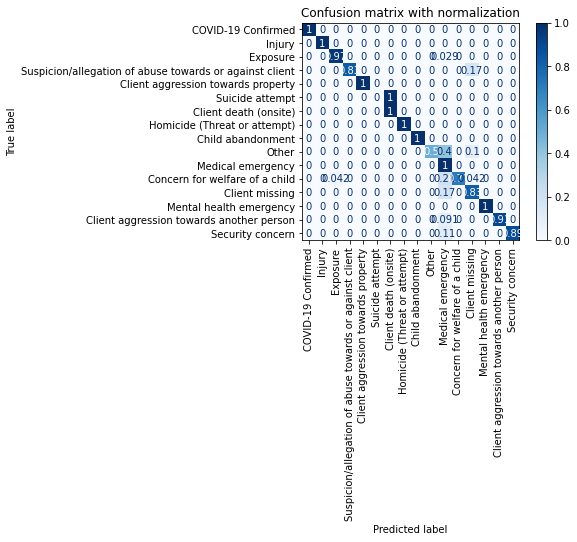

In [156]:
print("Complement NB train:\n")
utils.show_classification_report(
    cnb, X_train_set, y_train_set, sample_weight=weight_train
)

Complement NB test:

Accuracy: 82.97%
Balanced accuracy: 24.65%

Classification report:

                                                             precision    recall  f1-score   support

                   Client aggression towards another person       0.21      0.38      0.27      64.0
                         Client aggression towards property       0.00      0.00      0.00       9.0
                             Concern for welfare of a child       0.40      1.00      0.57      16.0
                               Homicide (Threat or attempt)       0.00      0.00      0.00       0.0
                                          Medical emergency       0.89      1.00      0.94    2025.0
                                    Mental health emergency       0.00      0.00      0.00      81.0
                                                      Other       0.52      0.33      0.41     225.0
                                           Security concern       1.00      0.25      0.40      16.0
 

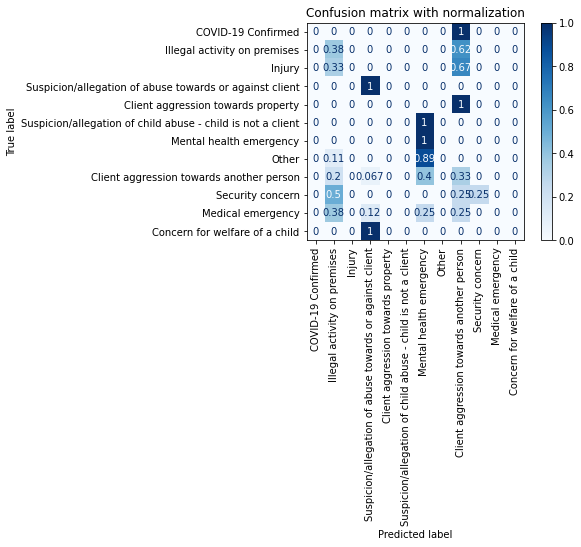

In [157]:
print("Complement NB test:\n")
utils.show_classification_report(cnb, X_test_set, y_test_set, sample_weight=weight_test)

SVM-C train:

Accuracy: 96.65%
Balanced accuracy: 70.89%

Classification report:

                                                             precision    recall  f1-score   support

                   Client aggression towards another person       0.91      0.94      0.92    1156.0
                         Client aggression towards property       1.00      0.83      0.91      36.0
                             Concern for welfare of a child       1.00      1.00      1.00     225.0
                               Homicide (Threat or attempt)       0.00      0.00      0.00       1.0
                                          Medical emergency       0.97      1.00      0.98   19044.0
                                    Mental health emergency       1.00      0.75      0.86     576.0
                                                      Other       0.96      0.83      0.89    2704.0
                                           Security concern       1.00      0.81      0.89     256.0
        

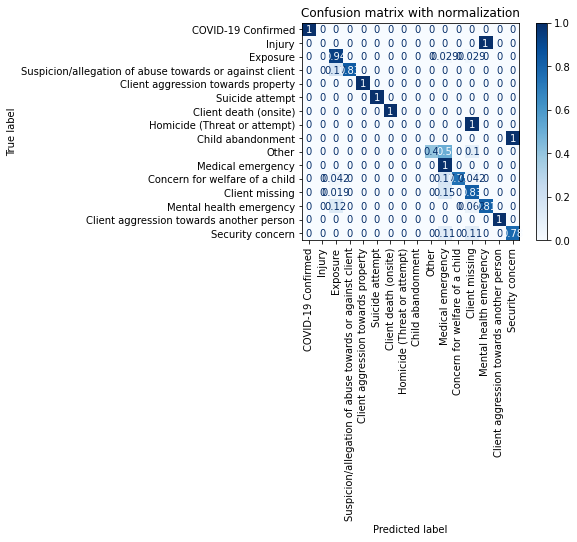

In [158]:
print("SVM-C train:\n")
utils.show_classification_report(
    svm, X_train_set, y_train_set, sample_weight=weight_train
)

SVM-C test:



c:\users\siepp\desktop\school\code-the-change\yw-nlp-report-classifier\.env\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Accuracy: 78.52%
Balanced accuracy: 27.36%

Classification report:

                                                             precision    recall  f1-score   support

                   Client aggression towards another person       0.28      0.50      0.36      64.0
                         Client aggression towards property       0.00      0.00      0.00       9.0
                             Concern for welfare of a child       0.40      1.00      0.57      16.0
                               Homicide (Threat or attempt)       0.00      0.00      0.00       0.0
                                          Medical emergency       0.90      0.93      0.92    2025.0
                                    Mental health emergency       0.14      0.11      0.12      81.0
                                                      Other       0.34      0.27      0.30     225.0
                                           Security concern       0.21      0.25      0.23      16.0
                      

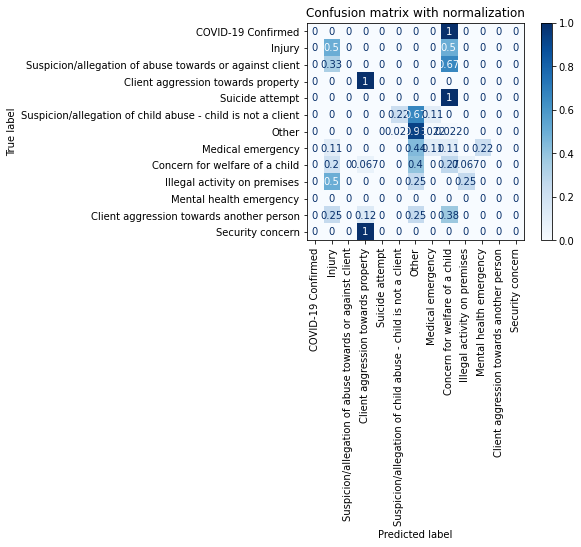

In [159]:
print("SVM-C test:\n")
utils.show_classification_report(svm, X_test_set, y_test_set, sample_weight=weight_test)